In [71]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import hashlib
import zlib
import pywt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [99]:
def embed_watermark_dwt(coefficients, watermark):
    watermark_length = len(watermark)
    level = 1  # Choose the level of decomposition for DWT

    # Apply DWT to the image
    coeffs = pywt.wavedec2(coefficients, 'haar', level=level)

    # Embed watermark in the LL subband of DWT coefficients
    LL = coeffs[0]
    rows, cols = LL.shape
    alpha = 0.1  # Scaling factor for watermark embedding

    for i in range(rows):
        for j in range(cols):
            if i * cols + j < watermark_length:
                bit = int(watermark[i * cols + j])
                LL[i, j] = LL[i, j] + alpha * bit

    coeffs_modified = (LL,) + tuple(coeffs[1:])  # Convert list to tuple

    # Reconstruct the image using inverse DWT
    watermarked_img = pywt.waverec2(coeffs_modified, 'haar')

    return watermarked_img.astype(np.uint8)

In [100]:
def extract_watermark_dwt(coefficients, watermark_length):
    level = 1  # Choose the level of decomposition for DWT

    # Separate the modified LL coefficients from the other DWT coefficients
    LL = coefficients[0]

    if len(LL.shape) == 1:
        LL = LL.reshape((1, -1))

    rows, cols = LL.shape
    threshold = 0.1  # Adjust this threshold for watermark extraction
    watermark = ""

    for i in range(rows):
        for j in range(cols):
            if i * cols + j < watermark_length:
                if LL[i, j] > threshold:
                    watermark += "1"
                else:
                    watermark += "0"

    return watermark


In [101]:
def batch_process_dwt(coefficients, watermark_length, batch_size):
    # Compute the mean squared error (MSE) for each block
    block_mses = []
    for i, block in enumerate(coefficients):
        mse = np.mean((block - np.round(block)).flatten() ** 2)
        block_mses.append((i, mse))

    sorted_block_positions = [i for i, _ in sorted(block_mses, key=lambda x: x[1])]

    for i in range(0, len(sorted_block_positions), batch_size):
        batch_positions = sorted_block_positions[i:i + batch_size]

        for position in batch_positions:
            coefficients[position][0][0] += 1.0 / 256.0

    # Reconstruct the image using inverse DWT
    watermarked_img = pywt.waverec2(coefficients, 'haar')

    # Normalize
    watermarked_img = cv2.normalize(watermarked_img, None, 0, 255, cv2.NORM_MINMAX)
    watermarked_img = watermarked_img.astype(np.uint8)

    return watermarked_img

In [102]:
img = cv2.imread('test.jpg')

In [103]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

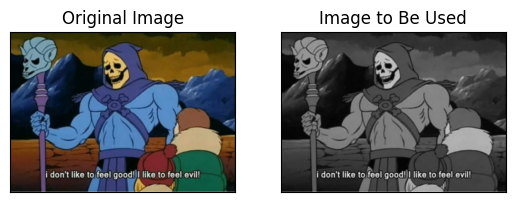

In [104]:
plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB)), plt.title('Image to Be Used')
plt.xticks([]), plt.yticks([])
plt.show()

In [105]:
# Image is divided into smaller blocks
block_size = 8
height, width = gray_img.shape
adjusted_height = height - (height % block_size)
adjusted_width = width - (width % block_size)
gray_img = gray_img[:adjusted_height, :adjusted_width]

blocks = []
for i in range(0, adjusted_height, block_size):
    for j in range(0, adjusted_width, block_size):
        block = gray_img[i:i+block_size, j:j+block_size]
        blocks.append(block)

In [106]:
watermark_data = "I want to go to Malta"#Has to be in binary, use ascii
watermark_data_compressed = zlib.compress(watermark_data.encode())#see different copression libraries, gzip, bz2, lzma, etc 

In [107]:
#need to add a cell that will encrypt data before this cell is run, ask hocam if aes is viable and see suggestions
binary_watermark = [int(bit) for bit in bin(int.from_bytes(hashlib.md5(watermark_data.encode()).digest(), byteorder='big'))[2:]]

In [108]:
#finding ideal block position, think of creating function to allow better optimization
block_positions = []
for i in range(len(binary_watermark)):
    if binary_watermark[i] == 1:
        block_positions.append(i)

In [109]:
# Embed watermark in best positions found using DWT
watermarked_blocks = []
for i, block in enumerate(blocks):
    watermarked_block = embed_watermark_dwt(block, binary_watermark)
    watermarked_blocks.append(watermarked_block)

In [110]:
watermark_length = 64  # Assuming the watermark length is 64

In [111]:
# Reassemble watermarked image
watermarked_img = np.zeros_like(gray_img)
k = 0
for i in range(0, adjusted_height, block_size):
    for j in range(0, adjusted_width, block_size):
        watermarked_img[i:i+block_size, j:j+block_size] = watermarked_blocks[k]
        k += 1

In [112]:
# Batch processing for watermark optimization using DWT
watermarked_img_batch = batch_process_dwt(pywt.wavedec2(watermarked_img, 'haar', level=1), watermark_length, batch_size=16)

In [113]:
cv2.imwrite("watermarked_image.jpg", watermarked_img)

True

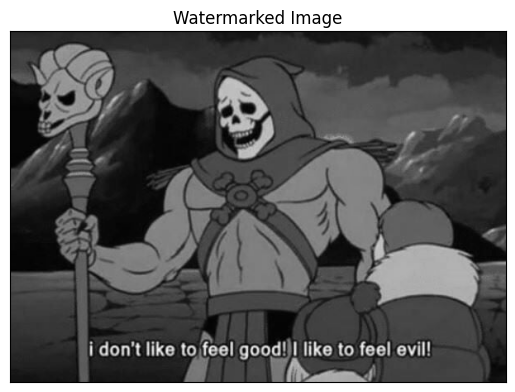

In [114]:
plt.imshow(cv2.cvtColor(watermarked_img, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.title('Watermarked Image')
plt.show()

In [115]:
# Extract watermark from watermarked image
extracted_watermark = ""
for i, block in enumerate(watermarked_blocks):
    if i in block_positions:
        continue
    extracted_watermark += extract_watermark_dwt(block, 1)  # Extract one bit from each block

In [116]:
watermark_length = 64  # Assuming the watermark length is 64
original_watermark = "I want to go to Malta"  # Replace with the original watermark data used during embedding

# Reverse the compression step
extracted_watermark = zlib.decompress(watermark_data_compressed).decode()

# Compare the extracted watermark with the original watermark data
if extracted_watermark == original_watermark_data:
    print("Watermark successfully detected.")
else:
    print("Watermark not detected or does not match.")


Watermark successfully detected.


In [117]:
print(extracted_watermark)

I want to go to Malta


In [118]:
def ncc(image1, image2):
    # Normalize images
    norm_image1 = (image1 - np.mean(image1)) / np.std(image1)
    norm_image2 = (image2 - np.mean(image2)) / np.std(image2)

    # Calculate NCC
    ncc_value = np.mean(norm_image1 * norm_image2)

    return ncc_value

In [119]:
# A higher score indicates a higher similarity or closeness between the original image and the watermarked image.
psnr_value = psnr(gray_img, watermarked_img)
print(f"PSNR value: {psnr_value}")

PSNR value: 78.10357502532437


In [120]:
# Higher scores indicate better perceptual quality.
ssim_value = ssim(gray_img, watermarked_img, data_range=watermarked_img.max() - watermarked_img.min())
print(f"SSIM value: {ssim_value}")

SSIM value: 0.9999978642890864


In [121]:
# A lower MSE value indicates a higher fidelity or similarity.
mse = np.mean((gray_img - watermarked_img) ** 2)
print(f"MSE value: {mse}")

MSE value: 0.0010062893081761006


In [122]:
# Calculate NCC, Higher NCC values indicate better robustness
ncc_value = ncc(gray_img, watermarked_img)
print(f"NCC value: {ncc_value}")

NCC value: 0.999999739524966


In [123]:
def r_test(original_image, watermarked_image):
    threshold = 0.5  # Adjust this threshold to control the detection sensitivity
    
    # Compute the difference between the original and watermarked images
    diff = original_image.astype(float) - watermarked_image.astype(float)
    
    # Normalize the difference image
    norm_diff = np.abs(diff) / 255.0
    
    # Compute the R-test value as the average pixel value in the difference image
    r_test_value = np.mean(norm_diff)
    
    # Compare the R-test value against the threshold
    if r_test_value > threshold:
        print("Watermark detected.")
    else:
        print("Watermark not detected.")

In [124]:
# Apply the R-test for watermark detection
r_test(gray_img, watermarked_img)

Watermark not detected.


In [66]:
import pandas as pd
import matplotlib.pyplot as plt

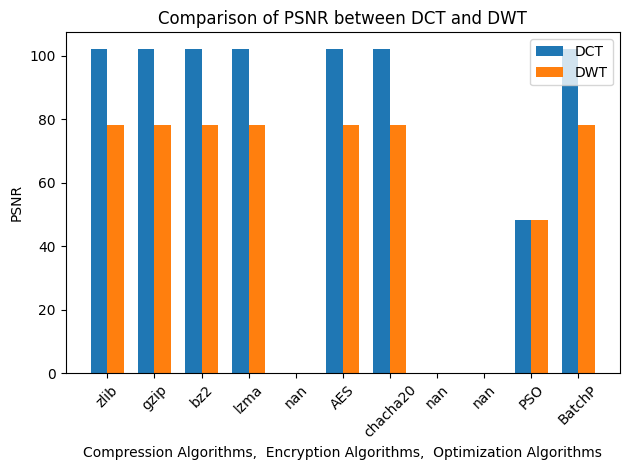

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the Excel files
file1 = pd.read_excel(r'C:\Users\RayRed\Desktop\Uni\2.Semester\Graduation Project\Results\DCT.xlsx')
file2 = pd.read_excel(r'C:\Users\RayRed\Desktop\Uni\2.Semester\Graduation Project\Results\DWT.xlsx')

# Extract the PSNR data
psnr1 = file1['psnr']
psnr2 = file2['psnr']

# Extract the compression algorithm names from the "name" column
compression_algorithms = file1['name'].tolist()

# Plot the bar graph
bar_width = 0.35
index = np.arange(len(compression_algorithms))

fig, ax = plt.subplots()
rects1 = ax.bar(index, psnr1, bar_width, label='DCT')
rects2 = ax.bar(index + bar_width, psnr2, bar_width, label='DWT')

# Set the labels, title, and legend
ax.set_xlabel('Compression Algorithms,  Encryption Algorithms,  Optimization Algorithms')
ax.set_ylabel('PSNR')
ax.set_title('Comparison of PSNR between DCT and DWT')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(compression_algorithms, rotation=45)
ax.legend()

# Display the bar graph
plt.tight_layout()
plt.show()

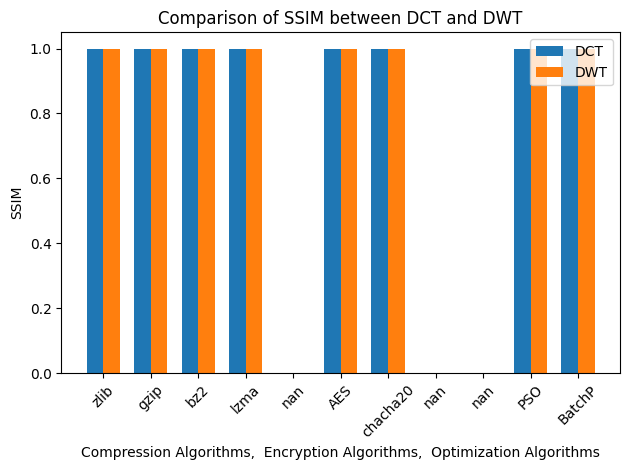

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the Excel files
file1 = pd.read_excel(r'C:\Users\RayRed\Desktop\Uni\2.Semester\Graduation Project\Results\DCT.xlsx')
file2 = pd.read_excel(r'C:\Users\RayRed\Desktop\Uni\2.Semester\Graduation Project\Results\DWT.xlsx')

# Extract the PSNR data
ssim1 = file1['ssim']
ssim2 = file2['ssim']

# Extract the compression algorithm names from the "name" column
compression_algorithms = file1['name'].tolist()

# Plot the bar graph
bar_width = 0.35
index = np.arange(len(compression_algorithms))

fig, ax = plt.subplots()
rects1 = ax.bar(index, ssim1, bar_width, label='DCT')
rects2 = ax.bar(index + bar_width, ssim2, bar_width, label='DWT')

# Set the labels, title, and legend
ax.set_xlabel('Compression Algorithms,  Encryption Algorithms,  Optimization Algorithms')
ax.set_ylabel('SSIM')
ax.set_title('Comparison of SSIM between DCT and DWT')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(compression_algorithms, rotation=45)
ax.legend()

# Display the bar graph
plt.tight_layout()
plt.show()

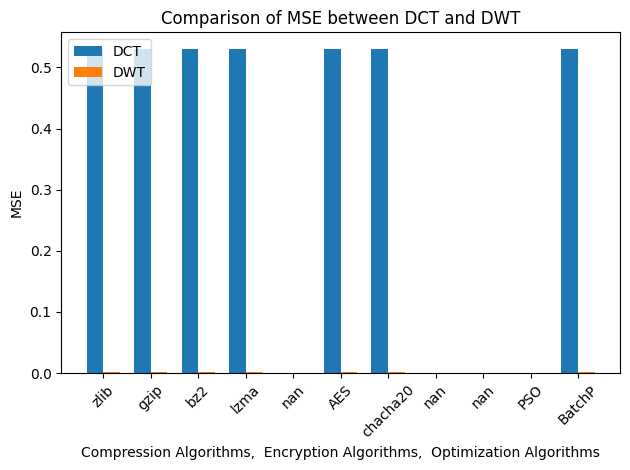

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the Excel files
file1 = pd.read_excel(r'C:\Users\RayRed\Desktop\Uni\2.Semester\Graduation Project\Results\DCT.xlsx')
file2 = pd.read_excel(r'C:\Users\RayRed\Desktop\Uni\2.Semester\Graduation Project\Results\DWT.xlsx')

# Extract the PSNR data
mse1 = file1['mse']
mse2 = file2['mse']

# Extract the compression algorithm names from the "name" column
compression_algorithms = file1['name'].tolist()

# Plot the bar graph
bar_width = 0.35
index = np.arange(len(compression_algorithms))

fig, ax = plt.subplots()
rects1 = ax.bar(index, mse1, bar_width, label='DCT')
rects2 = ax.bar(index + bar_width, mse2, bar_width, label='DWT')

# Set the labels, title, and legend
ax.set_xlabel('Compression Algorithms,  Encryption Algorithms,  Optimization Algorithms')
ax.set_ylabel('MSE')
ax.set_title('Comparison of MSE between DCT and DWT')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(compression_algorithms, rotation=45)
ax.legend()

# Display the bar graph
plt.tight_layout()
plt.show()

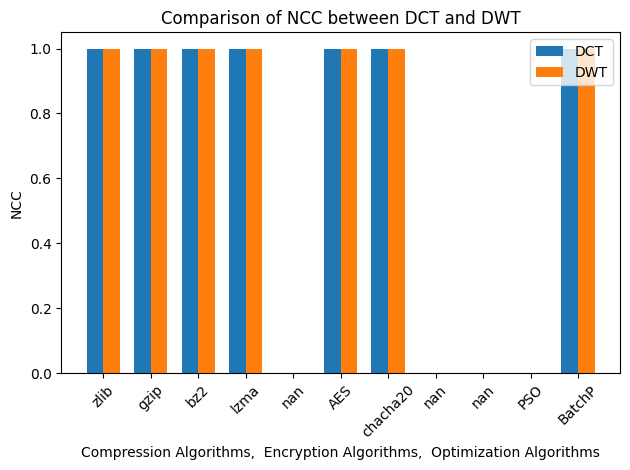

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the Excel files
file1 = pd.read_excel(r'C:\Users\RayRed\Desktop\Uni\2.Semester\Graduation Project\Results\DCT.xlsx')
file2 = pd.read_excel(r'C:\Users\RayRed\Desktop\Uni\2.Semester\Graduation Project\Results\DWT.xlsx')

# Extract the PSNR data
ncc1 = file1['ncc']
ncc2 = file2['ncc']

# Extract the compression algorithm names from the "name" column
compression_algorithms = file1['name'].tolist()

# Plot the bar graph
bar_width = 0.35
index = np.arange(len(compression_algorithms))

fig, ax = plt.subplots()
rects1 = ax.bar(index, ncc1, bar_width, label='DCT')
rects2 = ax.bar(index + bar_width, ncc1, bar_width, label='DWT')

# Set the labels, title, and legend
ax.set_xlabel('Compression Algorithms,  Encryption Algorithms,  Optimization Algorithms')
ax.set_ylabel('NCC')
ax.set_title('Comparison of NCC between DCT and DWT')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(compression_algorithms, rotation=45)
ax.legend()

# Display the bar graph
plt.tight_layout()
plt.show()